# *3章 血圧別発生率に挑戦*

# $\fbox{3-1}$「国民健康・栄養調査」の利用

### 国民健康・栄養調査


### 読み込みと整形

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc
import math
import pickle

# 本書 1-3 章の関数群を含む自作ライブラリ
import mylibs.mylib1 as mylib1
import mylibs.mylib2 as mylib2
import mylibs.mylib3 as mylib3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 8
pd.options.display.max_columns = 12

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
df_bp = pd.read_csv('./public_stats/original/nhns_bp.csv', skiprows=6)

df_bp.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,総 数,Unnamed: 4,20-29歳,...,Unnamed: 16,（再掲）40-89歳,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,NaN,NaN,人数,%,人数,...,%,人数,%,NaN,NaN,NaN
1,男性,収縮期（最高）血圧,総数,"1,293",100.0,64,...,100.0,"1,125",100.0,NaN,NaN,NaN
2,NaN,NaN,90mmHg未満,0,0,0,...,0.0,0,0.0,NaN,NaN,NaN
3,NaN,NaN,90- 99,13,1,5,...,0.2,6,0.5,NaN,NaN,NaN
4,NaN,NaN,100-109,64,4.9,15,...,1.8,31,2.8,NaN,NaN,NaN


In [3]:
df_bp = df_bp.loc[:, df_bp.columns[df_bp.iloc[0] != '%']]

df_bp.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,総 数,20-29歳,30-39歳,...,60-69歳,70歳以上,（再掲）40-89歳,Unnamed: 19,Unnamed: 20,Unnamed: 21
0,NaN,NaN,NaN,人数,人数,人数,...,人数,人数,人数,NaN,NaN,NaN
1,男性,収縮期（最高）血圧,総数,"1,293",64,94,...,341,500,"1,125",NaN,NaN,NaN
2,NaN,NaN,90mmHg未満,0,0,0,...,0,0,0,NaN,NaN,NaN
3,NaN,NaN,90- 99,13,5,2,...,1,1,6,NaN,NaN,NaN
4,NaN,NaN,100-109,64,15,18,...,9,9,31,NaN,NaN,NaN


In [4]:
df_bp = df_bp.loc[1:, df_bp.columns[:10]]
df_bp = df_bp.fillna(method='ffill')

df_bp.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,総 数,20-29歳,30-39歳,40-49歳,50-59歳,60-69歳,70歳以上
1,男性,収縮期（最高）血圧,総数,"1,293",64,94,128,166,341,500
2,男性,収縮期（最高）血圧,90mmHg未満,0,0,0,0,0,0,0
3,男性,収縮期（最高）血圧,90- 99,13,5,2,3,1,1,1
4,男性,収縮期（最高）血圧,100-109,64,15,18,9,4,9,9
5,男性,収縮期（最高）血圧,110-119,172,18,30,26,31,31,36


In [5]:
df_bp.columns = ['sex', 'bp_type', 'bp_value', 'total',
                 '20s', '30s', '40s', '50s', '60s', '70s']

df_bp.tail()

,sex,bp_type,bp_value,total,20s,30s,40s,50s,60s,70s
48,女性,拡張期（最低）血圧,120-129,1,0,0,0,0,0,1
49,女性,拡張期（最低）血圧,130-139,0,0,0,0,0,0,0
50,女性,拡張期（最低）血圧,140ｍｍHg以上,0,0,0,0,0,0,0
51,注１）血圧の測定を行った20歳以上の者を集計対象とした。,拡張期（最低）血圧,140ｍｍHg以上,0,0,0,0,0,0,0
52,注２）数値は２回の測定値の平均値を用いた。なお、１回しか測定できなかった者については、その値...,拡張期（最低）血圧,140ｍｍHg以上,0,0,0,0,0,0,0


In [6]:
df_bp = df_bp.iloc[:50]
df_bp = df_bp.loc[df_bp.bp_value != '総数', :]

df_bp

,sex,bp_type,bp_value,total,20s,30s,40s,50s,60s,70s
2,男性,収縮期（最高）血圧,90mmHg未満,0,0,0,0,0,0,0
3,男性,収縮期（最高）血圧,90- 99,13,5,2,3,1,1,1
4,男性,収縮期（最高）血圧,100-109,64,15,18,9,4,9,9
5,男性,収縮期（最高）血圧,110-119,172,18,30,26,31,31,36
...,...,...,...,...,...,...,...,...,...,...
47,女性,拡張期（最低）血圧,110-119,5,0,0,1,2,1,1
48,女性,拡張期（最低）血圧,120-129,1,0,0,0,0,0,1
49,女性,拡張期（最低）血圧,130-139,0,0,0,0,0,0,0
50,女性,拡張期（最低）血圧,140ｍｍHg以上,0,0,0,0,0,0,0


In [7]:
df_bp.sex[df_bp.sex == '男性'] = 'M'
df_bp.sex[df_bp.sex == '女性'] = 'F'
df_bp.bp_type[df_bp.bp_type == '収縮期（最高）血圧'] = 'sbp'
df_bp.bp_type[df_bp.bp_type == '拡張期（最低）血圧'] = 'dbp'
df_bp = df_bp.reset_index()
del df_bp['index']

df_bp

,sex,bp_type,bp_value,total,20s,30s,40s,50s,60s,70s
0,M,sbp,90mmHg未満,0,0,0,0,0,0,0
1,M,sbp,90- 99,13,5,2,3,1,1,1
2,M,sbp,100-109,64,15,18,9,4,9,9
3,M,sbp,110-119,172,18,30,26,31,31,36
...,...,...,...,...,...,...,...,...,...,...
42,F,dbp,110-119,5,0,0,1,2,1,1
43,F,dbp,120-129,1,0,0,0,0,0,1
44,F,dbp,130-139,0,0,0,0,0,0,0
45,F,dbp,140ｍｍHg以上,0,0,0,0,0,0,0


In [8]:
df_bp.bp_value.unique()

array(['90mmHg未満', '90- 99', '100-109', '110-119', '120-129', '130-139',
       '140-149', '150-159', '160-169', '170-179', '180mmHg以上',
       '40mmHg未満', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99',
       '140ｍｍHg以上'], dtype=object)

In [9]:
sbp_min = np.concatenate([[70], np.arange(9, 19) * 10])

sbp_min

array([ 70,  90, 100, 110, 120, 130, 140, 150, 160, 170, 180])

In [10]:
sbp_max = np.concatenate([sbp_min[1:] - 1, [199]])

sbp_max

array([ 89,  99, 109, 119, 129, 139, 149, 159, 169, 179, 199])

In [11]:
dbp_min = np.arange(4, 15) * 10

dbp_min

array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140])

In [12]:
dbp_max = np.concatenate([dbp_min[1:] - 1, [159]])

dbp_max

array([ 49,  59,  69,  79,  89,  99, 109, 119, 129, 139, 159])

In [13]:
dict_sbp_max = {k: v for (k, v) in zip(sbp_min, sbp_max)}
dict_dbp_max = {k: v for (k, v) in zip(dbp_min, dbp_max)}

dict_sbp_max

{70: 89,
 90: 99,
 100: 109,
 110: 119,
 120: 129,
 130: 139,
 140: 149,
 150: 159,
 160: 169,
 170: 179,
 180: 199}

In [14]:
df_bp = df_bp[df_bp['bp_value'] != '40mmHg未満'].copy()
df_bp['bp_min'] = np.tile(np.concatenate([sbp_min, dbp_min]), 2)
del df_bp['bp_value']
del df_bp['total']

df_bp

,sex,bp_type,20s,30s,40s,50s,60s,70s,bp_min
0,M,sbp,0,0,0,0,0,0,70
1,M,sbp,5,2,3,1,1,1,90
2,M,sbp,15,18,9,4,9,9,100
3,M,sbp,18,30,26,31,31,36,110
...,...,...,...,...,...,...,...,...,...
42,F,dbp,0,0,1,2,1,1,110
43,F,dbp,0,0,0,0,0,1,120
44,F,dbp,0,0,0,0,0,0,130
45,F,dbp,0,0,0,0,0,0,140


In [15]:
df_bp.dtypes

sex        object
bp_type    object
20s        object
30s        object
            ...  
50s        object
60s        object
70s        object
bp_min      int64
Length: 9, dtype: object

In [16]:
df_bp[df_bp.columns[2:]] = df_bp[df_bp.columns[2:]].copy().astype('int16')

df_bp.dtypes

sex        object
bp_type    object
20s         int16
30s         int16
            ...  
50s         int16
60s         int16
70s         int16
bp_min      int16
Length: 9, dtype: object

In [17]:
ages = df_bp.columns[2:8]  # ages = ['20s', ... , '70s']
# SBP の男性回答者数
df_bp.loc[(df_bp.sex == 'M') & (df_bp.bp_type == 'sbp'), ages].sum()

20s     64
30s     94
40s    128
50s    166
60s    341
70s    500
dtype: int64

In [18]:
# DBP の男性回答者数
df_bp.loc[(df_bp.sex == 'M') & (df_bp.bp_type == 'dbp'), ages].sum()

20s     64
30s     94
40s    128
50s    166
60s    341
70s    500
dtype: int64

In [19]:
sex = 'M'
bp_type = 'sbp'
age = '20s'

# 指定する (sex, bp_type, age) における回答者数リスト
ix = (df_bp.sex == sex) & (df_bp.bp_type == bp_type)
n = df_bp.loc[ix, age].values

# リスト n に対応する bp_min リスト
bp_min = df_bp.loc[ix, 'bp_min'].values

print('n =', n)
print('bp_min =', bp_min)

n = [ 0  5 15 18 18  7  0  1  0  0  0]
bp_min = [ 70  90 100 110 120 130 140 150 160 170 180]


In [20]:
bp_min.repeat(n)

array([ 90,  90,  90,  90,  90, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 130, 130, 130, 130, 130, 130, 130, 150],
      dtype=int16)

In [21]:
bp_min.repeat(n)
dict_bp_min_dist = {}
dict_bp_min_dist['M'] = {}
dict_bp_min_dist['M']['dbp'] = {}
dict_bp_min_dist['M']['sbp'] = {}
dict_bp_min_dist['F'] = {}
dict_bp_min_dist['F']['dbp'] = {}
dict_bp_min_dist['F']['sbp'] = {}

for sex in ['M', 'F']:
    for bp_type in ['sbp', 'dbp']:
        for age in ages:
            dict_bp_min_dist[sex][bp_type][age] = {}
            ix = (df_bp.sex == sex) & (df_bp.bp_type == bp_type)
            n = df_bp.loc[ix, age].values
            bp_min = df_bp.loc[ix, 'bp_min'].values
            dict_bp_min_dist[sex][bp_type][age] = bp_min.repeat(n)

In [22]:
dict_bp_min_dist['M']['sbp']['20s']

array([ 90,  90,  90,  90,  90, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 130, 130, 130, 130, 130, 130, 130, 150],
      dtype=int16)

In [23]:
import pickle

f = open('./public_stats/processed/dict_bp_min_dist.binaryfile', 'wb')  # wb: Write Binary
pickle.dump(dict_bp_min_dist, f)
f.close()

In [24]:
f = open('./public_stats/processed/dict_bp_min_dist.binaryfile', 'rb')  # rb: Read Binary
dict_bp_min_dist = pickle.load(f)
f.close()

dict_bp_min_dist['M']['sbp']['20s']

array([ 90,  90,  90,  90,  90, 100, 100, 100, 100, 100, 100, 100, 100,
       100, 100, 100, 100, 100, 100, 100, 110, 110, 110, 110, 110, 110,
       110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 110, 120,
       120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120,
       120, 120, 120, 120, 130, 130, 130, 130, 130, 130, 130, 150],
      dtype=int16)

In [25]:
f = open('./public_stats/processed/dict_dbp_max.binaryfile', 'wb')  # wb: Write Binary
pickle.dump(dict_dbp_max, f)
f.close()

f = open('./public_stats/processed/dict_sbp_max.binaryfile', 'wb')  # wb: Write Binary
pickle.dump(dict_sbp_max, f)
f.close()

In [26]:
f = open('./public_stats/processed/dict_dbp_max.binaryfile', 'rb')  # rb: Read Binary
dict_dbp_min = pickle.load(f)
f.close()

dict_dbp_min

{40: 49,
 50: 59,
 60: 69,
 70: 79,
 80: 89,
 90: 99,
 100: 109,
 110: 119,
 120: 129,
 130: 139,
 140: 159}

In [27]:
f = open('./public_stats/processed/dict_sbp_max.binaryfile', 'rb')  # rb: Read Binary
dict_sbp_min = pickle.load(f)
f.close()

dict_sbp_min

{70: 89,
 90: 99,
 100: 109,
 110: 119,
 120: 129,
 130: 139,
 140: 149,
 150: 159,
 160: 169,
 170: 179,
 180: 199}

In [28]:
df_bp.to_csv('./public_stats/processed/df_bp.csv', index=False)

df_bp = pd.read_csv('./public_stats/processed/df_bp.csv')
df_bp

,sex,bp_type,20s,30s,40s,50s,60s,70s,bp_min
0,M,sbp,0,0,0,0,0,0,70
1,M,sbp,5,2,3,1,1,1,90
2,M,sbp,15,18,9,4,9,9,100
3,M,sbp,18,30,26,31,31,36,110
...,...,...,...,...,...,...,...,...,...
40,F,dbp,0,0,1,2,1,1,110
41,F,dbp,0,0,0,0,0,1,120
42,F,dbp,0,0,0,0,0,0,130
43,F,dbp,0,0,0,0,0,0,140


### 血圧情報の擬似生成と可視化

In [29]:
def calc_bp_class(dbp, sbp):
    return ((dbp >= 80) | (sbp >= 120)) * 1 \
         + ((dbp >= 85) | (sbp >= 130)) * 1 \
         + ((dbp >= 90) | (sbp >= 140)) * 1 \
         + ((dbp >= 100) | (sbp >= 160)) * 1 \
         + ((dbp >= 110) | (sbp >= 180)) * 1


# 年齢ごとにマーカーの色を変える
dict_color = {'20s': 'r', '30s': 'orange', '40s': 'y',
              '50s': 'g', '60s': 'b', '70s': 'purple'}

# マーカーを血圧分類値にする
dict_marker = {0: '$0$', 1: '$1$', 2: '$2$', 3: '$3$', 4: '$4$', 5: '$5$'}

<IPython.core.display.Javascript object>


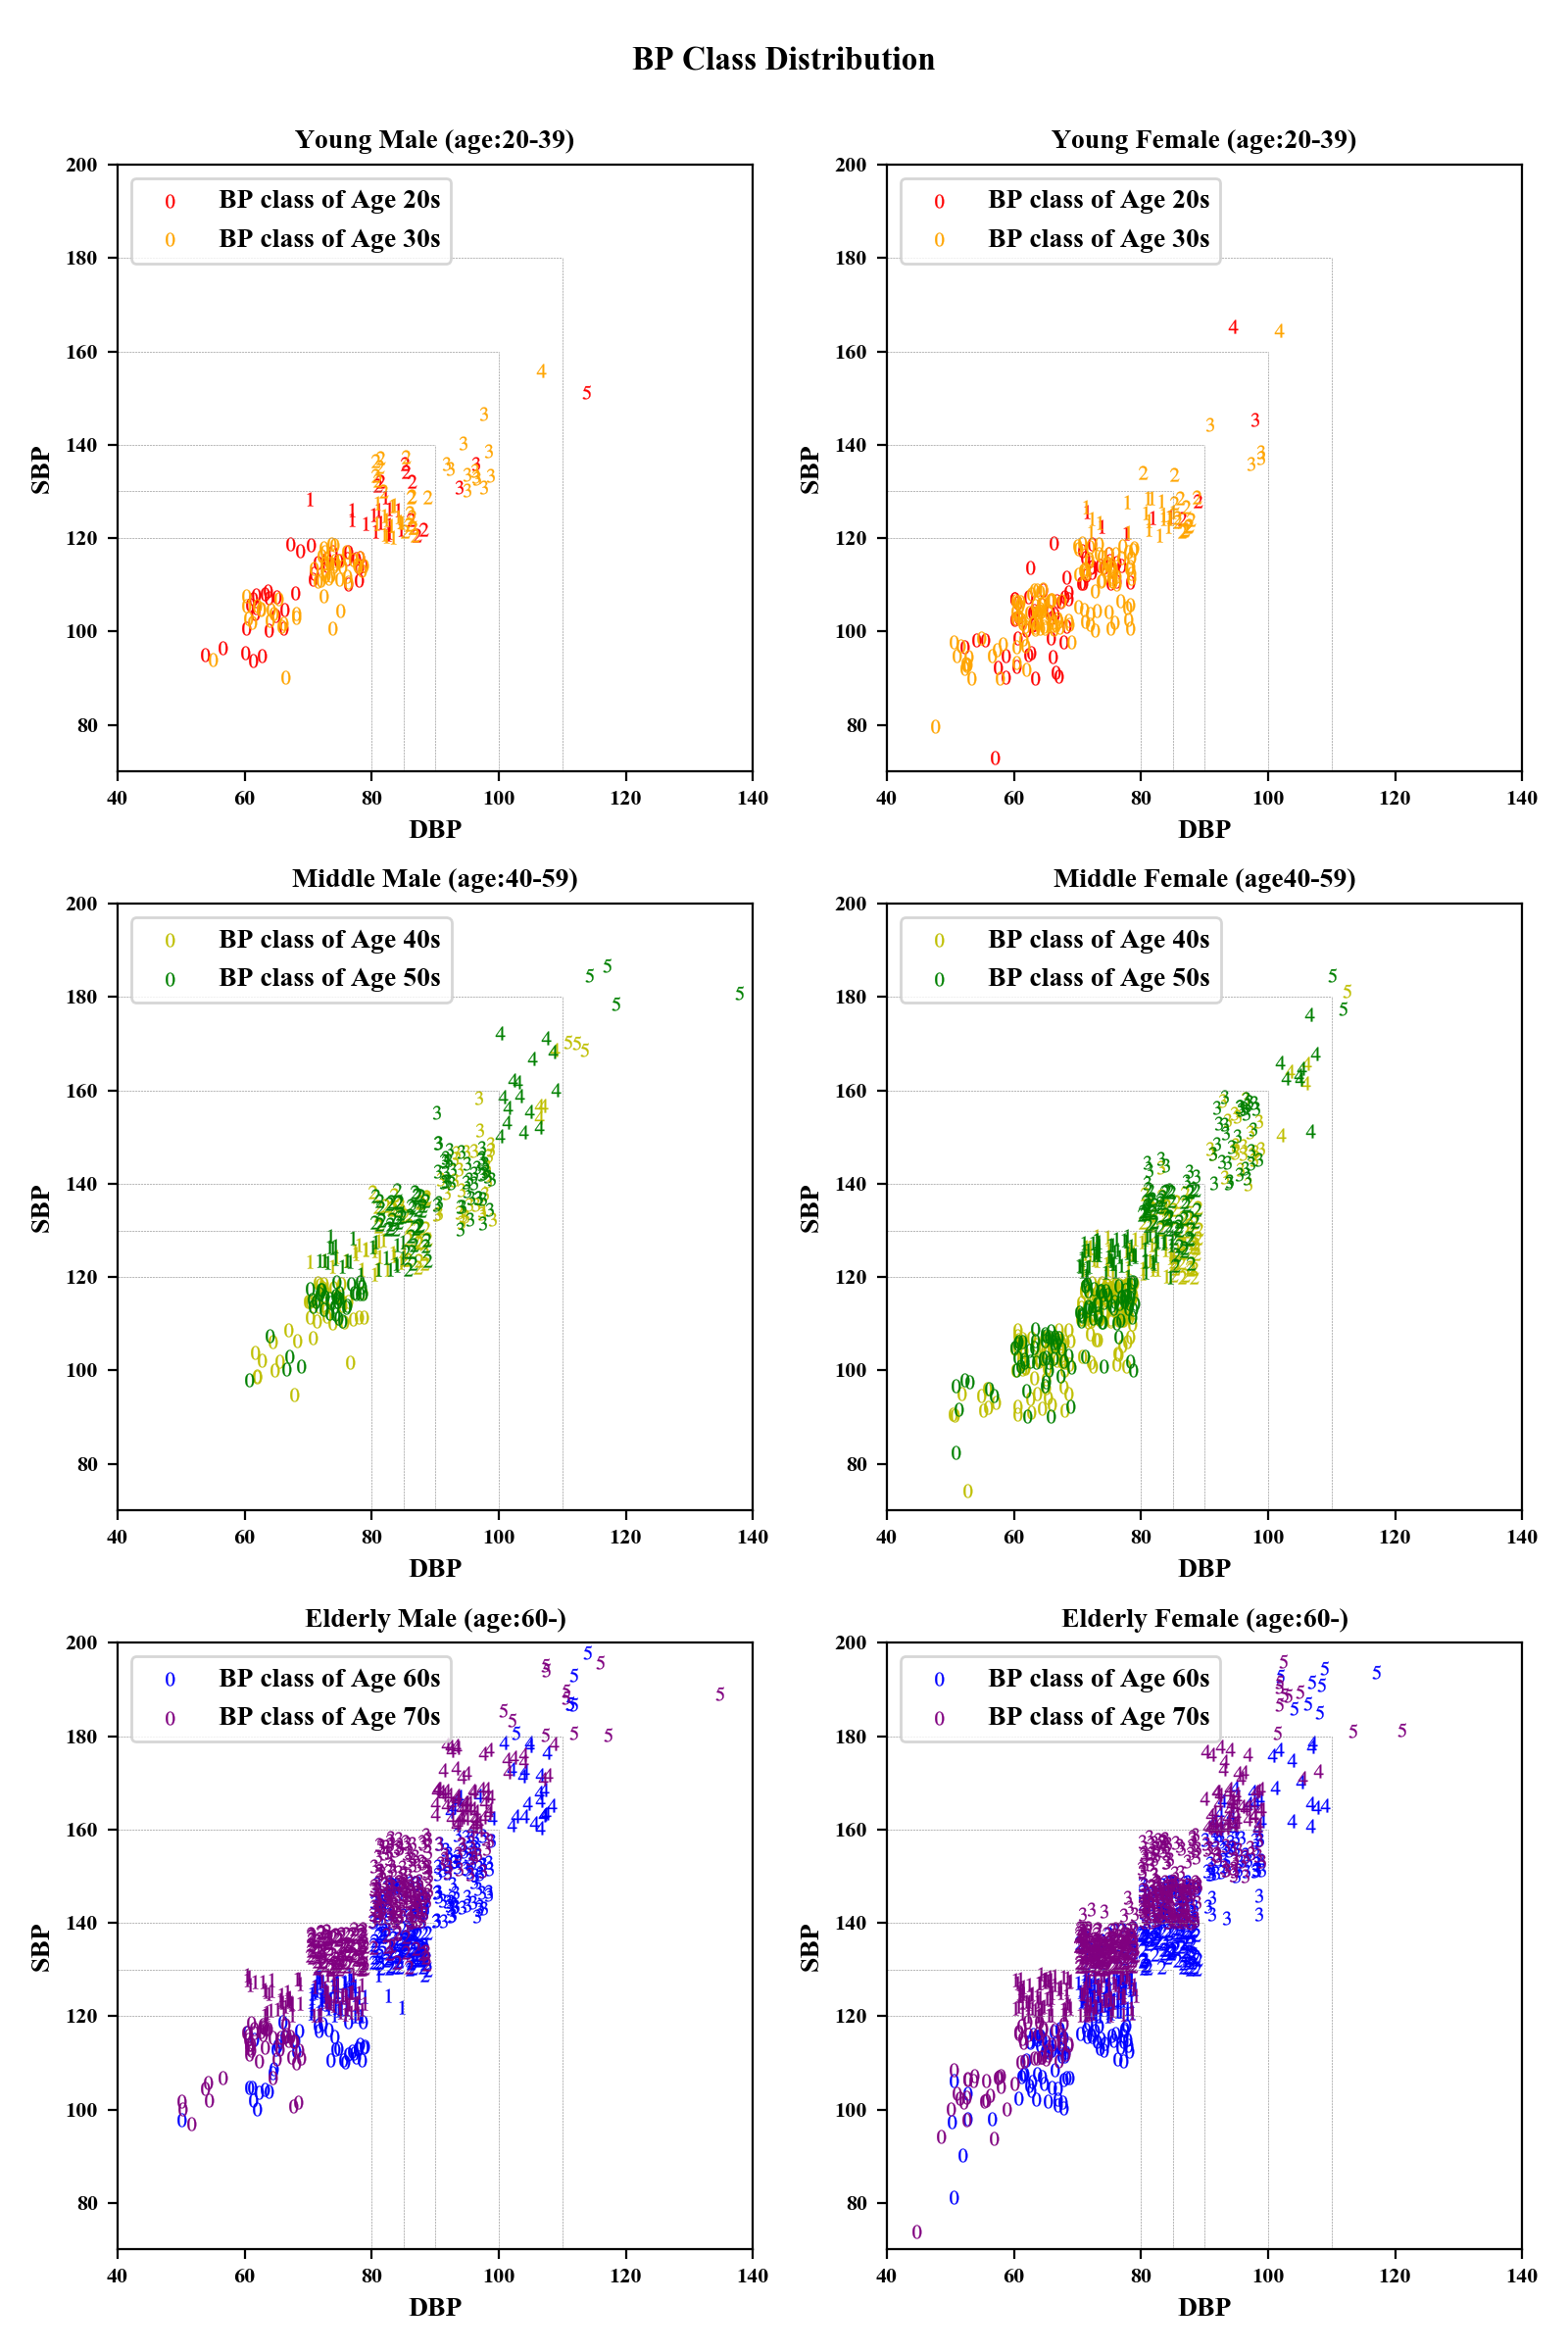

In [30]:
# 表示の大きさと解像度を設定
fig = plt.figure(figsize=(8, 12))
fig.suptitle('BP Class Distribution')

# 6つの散布図を同時に表示
ax_My = fig.add_subplot(321)  # Male   Young
ax_Fy = fig.add_subplot(322)  # Female Young
ax_Mm = fig.add_subplot(323)  # Male   Middle
ax_Fm = fig.add_subplot(324)  # Female Middle
ax_Me = fig.add_subplot(325)  # Male   Elderly
ax_Fe = fig.add_subplot(326)  # Female Elderly

rs = 0
np.random.seed(rs)

sexes = ['M', 'F']
ages = df_bp.columns[2:8]

for sex in sexes:
    for age in ages:
        sbp_min = dict_bp_min_dist[sex]['sbp'][age]
        sbp_max = [dict_sbp_max[sbpm] for sbpm in sbp_min]
        dbp_min = dict_bp_min_dist[sex]['dbp'][age]
        dbp_max = [dict_dbp_max[dbpm] for dbpm in dbp_min]
        n = len(sbp_min)

        # SBP を乱数生成
        sbp = np.random.rand(n) * (sbp_max - sbp_min) + sbp_min
        rs = rs + 1
        np.random.seed(rs)

        # DBP を乱数生成
        dbp = np.random.rand(n) * (dbp_max - dbp_min) + dbp_min
        rs = rs + 1
        np.random.seed(rs)

        # 軸を選ぶ
        if sex == 'M' and (age == '20s' or age == '30s'):
            ax = ax_My
        elif sex == 'M' and (age == '40s' or age == '50s'):
            ax = ax_Mm
        elif sex == 'M' and (age == '60s' or age == '70s'):
            ax = ax_Me
        elif sex == 'F' and (age == '20s' or age == '30s'):
            ax = ax_Fy
        elif sex == 'F' and (age == '40s' or age == '50s'):
            ax = ax_Fm
        else:
            ax = ax_Fe

        # 各性別・年齢区分における最初の人だけ凡例をつける
        marker = calc_bp_class(dbp, sbp)
        for m in np.arange(6):
            x = dbp[marker == m]
            y = sbp[marker == m]
            if m == 0:
                ax.scatter(x, y, c=dict_color[age], marker=dict_marker[m],
                           s=25, linewidth=0.1, label='BP class of Age ' + age)
            else:
                ax.scatter(x, y, c=dict_color[age], marker=dict_marker[m],
                           s=25, linewidth=0.1)

axes = [ax_My, ax_Mm, ax_Me, ax_Fy, ax_Fm, ax_Fe]

# 血圧分類の境界を作成
for ax in axes:
    # vertical lines
    ax.plot([80, 80], [70, 120], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([85, 85], [70, 130], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([90, 90], [70, 140], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([100, 100], [70, 160], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([110, 110], [70, 180], linestyle='--', c='grey', linewidth=0.2)
    # horizontal lines
    ax.plot([40, 80], [120, 120], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([40, 85], [130, 130], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([40, 90], [140, 140], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([40, 100], [160, 160], linestyle='--', c='grey', linewidth=0.2)
    ax.plot([40, 110], [180, 180], linestyle='--', c='grey', linewidth=0.2)

# 各散布図にタイトルを追加
titles = ['Young Male (age:20-39)', 'Middle Male (age:40-59)',
          'Elderly Male (age:60-)', 'Young Female (age:20-39)',
          'Middle Female (age40-59)', 'Elderly Female (age:60-)']
for ax, title in zip(axes, titles):
    ax.set_xlabel('DBP', fontsize=10)
    ax.set_ylabel('SBP', fontsize=10)
    ax.set_xlim(40, 140)
    ax.set_ylim(70, 200)
    ax.set_title(title, fontsize=10)
    ax.tick_params(labelsize=8)
    ax.legend(fontsize=10)

# 散布図同士の間隔調整
plt.tight_layout()
plt.subplots_adjust(top=0.93)

## まとめ